Load the CIFAR-10 dataset

In [3]:
# Import necessary libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


Using a pre-trained model to generate embeddings. ResNet50 model is pre-trained on the ImageNet dataset. Each embedding is a high-dimensional vector, and you can associate each one with the ID of the corresponding image.

In [4]:

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define batch size and number of batches
batch_size = 100
num_batches = len(train_images) // batch_size

# Initialize an empty array to hold the embeddings
train_embeddings = np.empty((len(train_images), 2048))

# Generate embeddings for the training images in batches
for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_images = train_images[start:end]
    
    # Resize images to match the input size for ResNet50
    batch_images = np.array([np.resize(img, (224, 224, 3)) for img in batch_images])
    
    # Preprocess images for ResNet50
    batch_images = preprocess_input(batch_images)
    
    # Generate embeddings for the batch
    batch_embeddings = model.predict(batch_images)
    
    # Store the embeddings in the array
    train_embeddings[start:end] = batch_embeddings

    print(f'Batch {i+1}/{num_batches} processed')

# If there are any remaining images that don't make up a full batch, process them separately
if len(train_images) % batch_size != 0:
    start = num_batches * batch_size
    batch_images = train_images[start:]
    
    # Resize and preprocess images
    batch_images = np.array([np.resize(img, (224, 224, 3)) for img in batch_images])
    batch_images = preprocess_input(batch_images)
    
    # Generate embeddings for the batch
    batch_embeddings = model.predict(batch_images)
    
    # Store the embeddings in the array
    train_embeddings[start:] = batch_embeddings

4/4 [==============================] - 11s 2s/step
Batch 1/500 processed
4/4 [==============================] - 8s 2s/step
Batch 2/500 processed
4/4 [==============================] - 9s 2s/step
Batch 3/500 processed
4/4 [==============================] - 9s 2s/step
Batch 4/500 processed
4/4 [==============================] - 9s 2s/step
Batch 5/500 processed
4/4 [==============================] - 8s 2s/step
Batch 6/500 processed
4/4 [==============================] - 8s 2s/step
Batch 7/500 processed
4/4 [==============================] - 10s 2s/step
Batch 8/500 processed
4/4 [==============================] - 10s 2s/step
Batch 9/500 processed
4/4 [==============================] - 8s 2s/step
Batch 10/500 processed
4/4 [==============================] - 7s 2s/step
Batch 11/500 processed
4/4 [==============================] - 7s 2s/step
Batch 12/500 processed
4/4 [==============================] - 7s 2s/step
Batch 13/500 processed
4/4 [==============================] - 8s 2s/step
Batch 1

Storing embeddings in a Faiss index

In [5]:
import faiss

# dimension of the embeddings
dimension = train_embeddings.shape[1]  
print(f'Embedding dimension: {dimension}')

index = faiss.IndexFlatL2(dimension)

# Convert the embeddings to float32 type
train_embeddings = train_embeddings.astype('float32')
# Add the embeddings to the index
index.add(train_embeddings)



Embedding dimension: 2048


Implement similarity search

In [6]:
def search_similar_images(query_image, k=10):
    # Resize and preprocess the query image
    query_image = np.resize(query_image, (224, 224, 3))
    query_image = preprocess_input(query_image)
    
    # Generate an embedding for the query image
    query_embedding = model.predict(np.expand_dims(query_image, axis=0))
    
    # Use Faiss to find the k most similar embeddings
    distances, indices = index.search(query_embedding, k)
    
    # Return the corresponding images
    similar_images = train_images[indices[0]]
    
    return similar_images, distances[0]

test image similarity

1/1 [==============================] - 0s 90ms/step


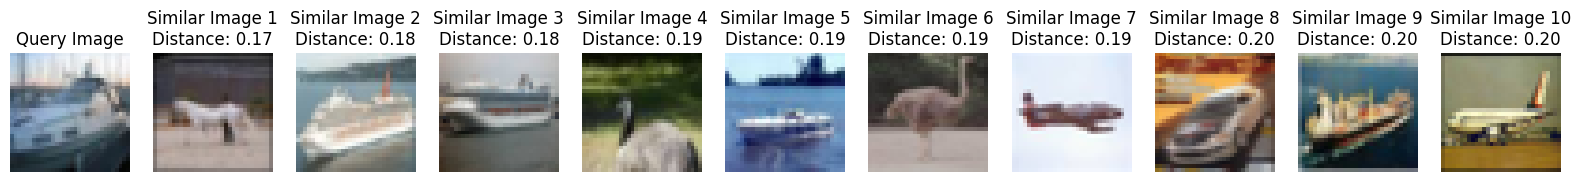

In [11]:
import matplotlib.pyplot as plt

# Choose a test image
query_image = test_images[2]

# Find similar images
similar_images, distances = search_similar_images(query_image)

# Display the query image
plt.figure(figsize=(20, 10))
plt.subplot(1, 11, 1)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')

# Display the similar images
for i, (image, distance) in enumerate(zip(similar_images, distances)):
    plt.subplot(1, 11, i+2)
    plt.imshow(image)
    plt.title(f"Similar Image {i+1}\nDistance: {distance:.2f}")
    plt.axis('off')

plt.show()

The similarity search in this context is based on the "feature space" defined by the ResNet50 model, not necessarily on semantic similarity that humans would recognize. The ResNet50 model generates a high-dimensional vector for each image, which captures complex features and patterns in the image. When we say that two images are "similar", it means that their vectors are close together in this high-dimensional space.

However, the features that the model captures are not always aligned with human perception. For example, the model might consider two images to be similar because they both have a similar color distribution, or because they both contain certain types of edges or textures, even if the images depict completely different objects.

In addition, the ResNet50 model was trained on the ImageNet dataset, which contains many different categories of images. The features that the model has learned to capture might not be the most relevant for distinguishing between the specific categories in the CIFAR-10 dataset.

If you want to improve the semantic accuracy of the similarity search, you could consider fine-tuning the ResNet50 model on the CIFAR-10 dataset before generating the embeddings. This would allow the model to learn features that are more specific to the categories in the CIFAR-10 dataset, which could improve the quality of the similarity search.